In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

import sklearn
from sklearn.mixture import GaussianMixture

## Black-hole binary formation channels with gaussian mixtures.

Many problems in astrophysics give rise to data with multiple modes. This is typically because different physical processes contribute to the observed dataset. 

For instance, one of the most outstanding question in gravitational-wave astrophysics is the formation channel of binary black holes. Leading scenarions include the evolution of isolated binaries in the galactic field and the dynamica assembly of sources in dense environments like globular clusters.

Anyway. LIGO measures the masses of many black holes. You can find the dataset at `solutions/formationchannels.npy`.


*Hint*: Note that the data provided are of shape (N,1), not (N,). This might be confusing at first, but it's the format that sklearn wants (more on this in a future lecture).  A useful tool to convert between the two is [np.newaxis](https://stackoverflow.com/questions/29241056/how-does-numpy-newaxis-work-and-when-to-use-it).

Some events form in different astrophysical environments than others. **You want to figure out how many of formation channels are at play.**


The strategy here is to fit a Gaussian Mixture model: that is, my model is a sum of $N$ gaussians each with mean $\mu_j$ and standard deviation $\sigma_j$ and weight $\alpha_j$:

$p(x_i|\theta) = \sum_{j=1}^N \alpha_j \mathcal{N}(\mu_j,\sigma_j) $

This depends on $3N-1$ parameters (not $3N$ because the sum of the $\alpha_j$ must be unity to ensure that this is a probability.

#### Tasks

1) Load this file (`np.load`) and complete a quick exploration of the data. How many modes do you think you see?

data shape: (2950, 1)


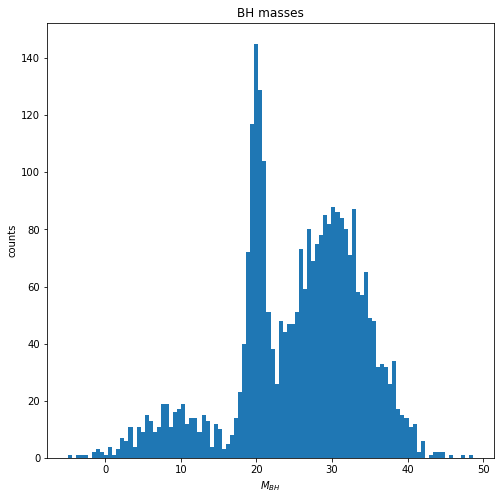

In [2]:
data = np.load("formationchannels.npy")

print('data shape:',data.shape)

figure = plt.figure(figsize=(8,8))

plt.hist(data,bins=100)
plt.title(r'BH masses')
plt.xlabel(r'$M_{BH}$')
plt.ylabel('counts')
plt.show()

2) Take some time to explore `sklearn.mixture.GaussianMixture`. Check the documentation, some examples, the help menu, etc. You first need to define the model (instance of a class), and then train it on the data using the `fit` method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.

*Note*. We'll do a more formal introduction to scikit-learn in one of the next lectures. This is meant to be a formative example on how you might find yourself dealing with a library you've never seen before. This happens *all the time* in scientific research!

3) Complete the fit 10 times with $N=1,...,10$ Gaussians. 

Note: `sklearn` by default will use the so-called [Expectation-Maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm), which is one of the many great things in data science we don't have time to study in detail.

4) For each of this fits, compute the AIC and the BIC (easy! They are attributes of the trained model!). Plot $N$ vs AIC and BIC: which model is preferred?

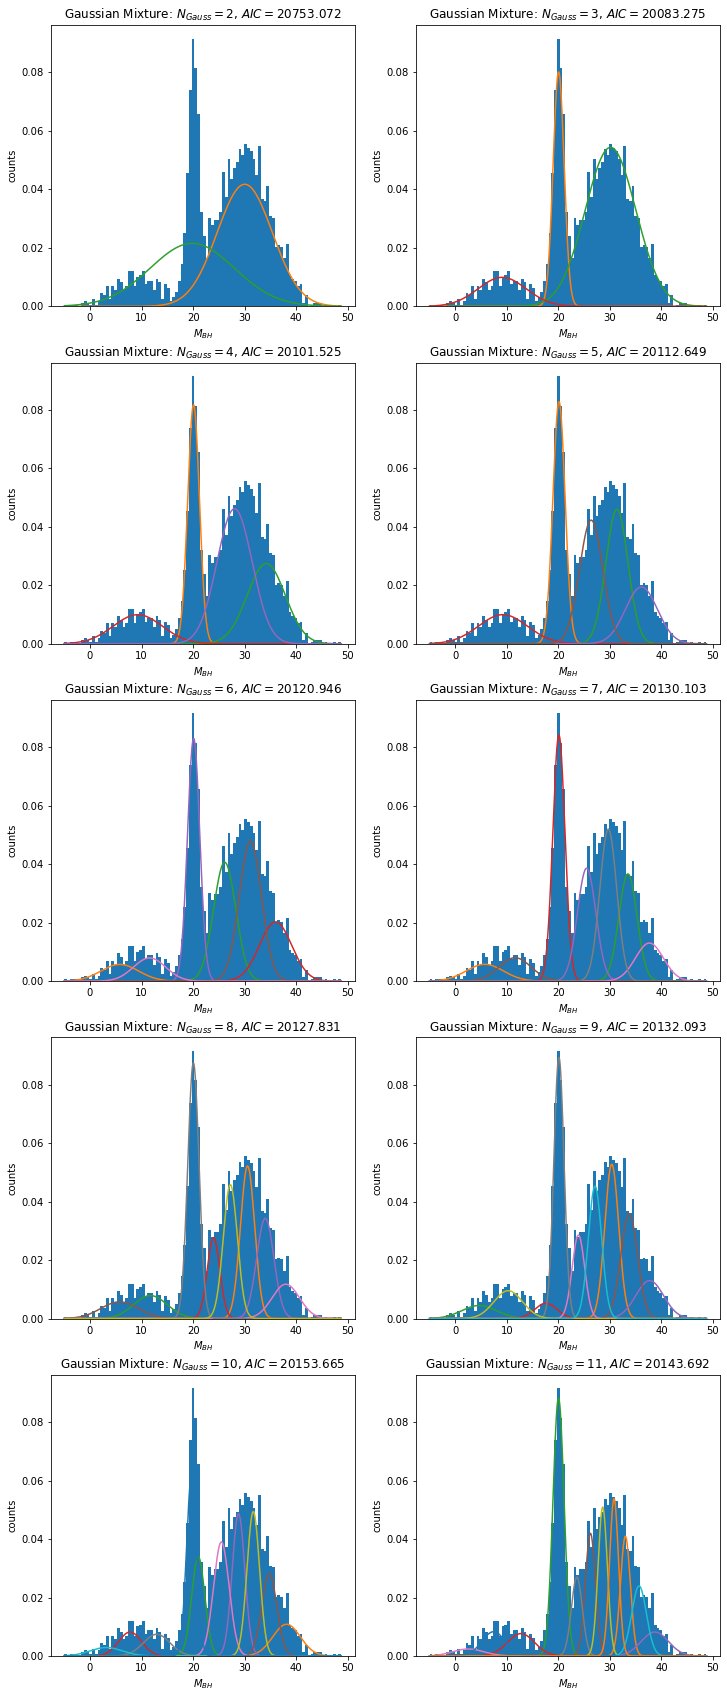

In [3]:
N_Gauss = np.arange(2,12) # why it doesn't work with N=1?
gm_fit = np.empty([len(N_Gauss)],dtype=object)
Gaussians = np.empty([len(N_Gauss),3],dtype=object) # mu,sigma,alpha
AIC = np.zeros(len(N_Gauss))
BIC = np.zeros(len(N_Gauss))

for i in range(len(N_Gauss)):
    # define the Gaussian Mixture model:
    GM_model = GaussianMixture(n_components=N_Gauss[i])
    
    # train the model with the data:
    gm = GM_model.fit(data)
    gm_fit[i] = gm
    
    # fill an array with the means and the std of the Gaussians identified
    Gaussians[i] = gm.means_, np.sqrt(gm.covariances_),gm.weights_
    
    # get the AIC
    AIC[i] = gm.aic(data)
    BIC[i] = gm.bic(data)
    
    
# plot
fig,ax = plt.subplots(nrows=5,ncols=2,figsize=(12,30))

x_grid = np.linspace(min(data),max(data),1000)

for i in range(len(N_Gauss)):
    ax = ax.ravel()
    ax[i].hist(data,bins=100,density=True)
    ax[i].set_title(r'Gaussian Mixture: $N_{Gauss}=%i$, $AIC=%.3f$'%(N_Gauss[i],AIC[i]))
    ax[i].set_xlabel(r'$M_{BH}$')
    ax[i].set_ylabel('counts')
    for j in range(N_Gauss[i]):
        # define the Gaussian with the mu and sigma extrapolated from GM
        mu = Gaussians[i][0][j]
        sigma = Gaussians[i][1][j]
        alpha = Gaussians[i][2][j]
        
        gauss_pdf = scipy.stats.norm(mu,sigma)
        
        # draw the Gaussian over the x_grid range
        ax[i].plot(x_grid,alpha*gauss_pdf.pdf(x_grid))

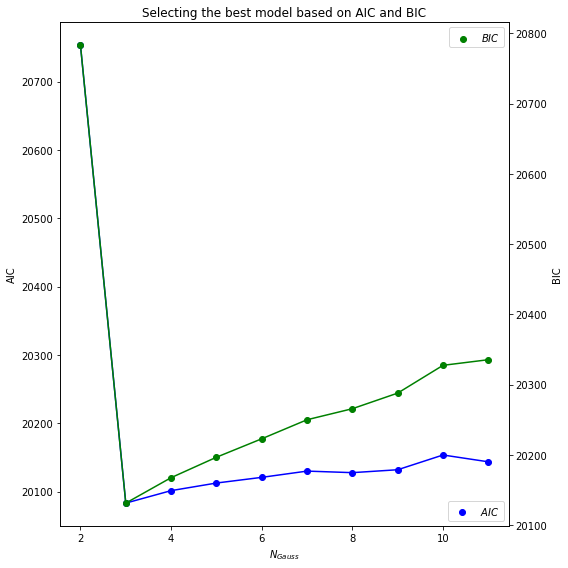

In [11]:
fig = plt.figure(figsize=(8,8))

# plot the AIC 
ax1 = fig.subplots()

ax1.plot(N_Gauss,AIC,color='blue')
ax1.scatter(N_Gauss,AIC,color='blue',label='$AIC$')
ax1.set_xlabel(r'$N_{Gauss}$')
ax1.set_ylabel('AIC')
ax1.legend(loc='lower right')

# plot the BIC
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

ax2.plot(N_Gauss,BIC,color='green')
ax2.scatter(N_Gauss,BIC,color='green',label='$BIC$')
ax2.set_ylabel('BIC')

plt.title('Selecting the best model based on AIC and BIC')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax2.legend(loc='upper right')
plt.show()

For both the model selection criteria, the $N_{gauss}=3$ model is the best one.

5) Plot the preferred solution on top of the input data. You should get a very nice fit!

6) Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset. 

*Hint:* Useful methods here are `score_samples` and `predict_proba`: you'll need them both. Try to understand what they do and how you can put them together.

Best GM model: N=3 Gaussians


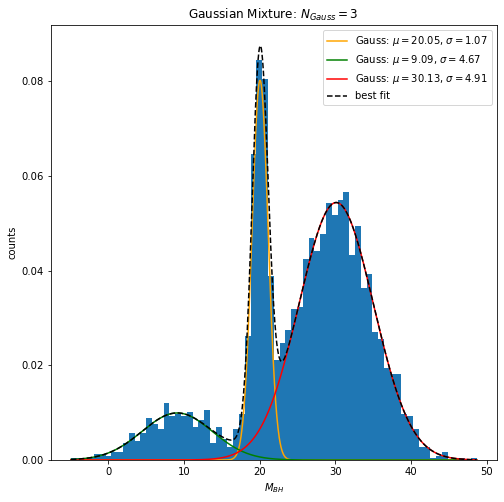

In [47]:
best_gm_model = N_Gauss[np.argmin(AIC)]
print('Best GM model: N=%i Gaussians'%best_gm_model)

mu_best = Gaussians[np.argmin(AIC)][0]
sigma_best = Gaussians[np.argmin(AIC)][1]
alpha_best = Gaussians[np.argmin(AIC)][2]
best_fit = gm_fit[np.argmin(AIC)]

log_L =  best_fit.score_samples(x_grid.reshape(-1,1)) # Log-likelihood of each sample in data under the current model
best_pdf = np.exp(log_L)

predict_class = best_fit.predict_proba(x_grid.reshape(-1, 1))
pdf_individual = predict_class * best_pdf[:,np.newaxis]

fig = plt.figure(figsize=(8,8))

fancyhist(data, 70, density=True);
plt.plot(x_grid, pdf_individual[:,0], c='orange',label='Gauss: $\mu=%.2f$, $\sigma=%.2f$'%(mu_best[0][0],sigma_best[0][0]))
plt.plot(x_grid, pdf_individual[:,1], c='green',label='Gauss: $\mu=%.2f$, $\sigma=%.2f$'%(mu_best[1][0],sigma_best[1][0]))
plt.plot(x_grid, pdf_individual[:,2], c='red',label='Gauss: $\mu=%.2f$, $\sigma=%.2f$'%(mu_best[2][0],sigma_best[2][0]))
plt.plot(x_grid, best_pdf, '--k',label='best fit')

plt.title(r'Gaussian Mixture: $N_{Gauss}=%i$'%(best_gm_model))
plt.xlabel(r'$M_{BH}$')
plt.ylabel('counts')
plt.legend()

### Meanshift try

Now I try to get a similar result (at least the same number of clusters) by using MeanShift. Meanshift not only estimates the cluster centers and boundaries, but it also estimates the number of clusters.

In [65]:
from sklearn.cluster import MeanShift
from sklearn import preprocessing

In [100]:
# rescale the data:
scaler = preprocessing.StandardScaler()
 
ms = MeanShift(bin_seeding=True, cluster_all=True) # define the estimator object estimating also the best bandwidth
ms.fit(scaler.fit_transform(data))

MeanShift(bin_seeding=True)

Number of estimated clusters: 3


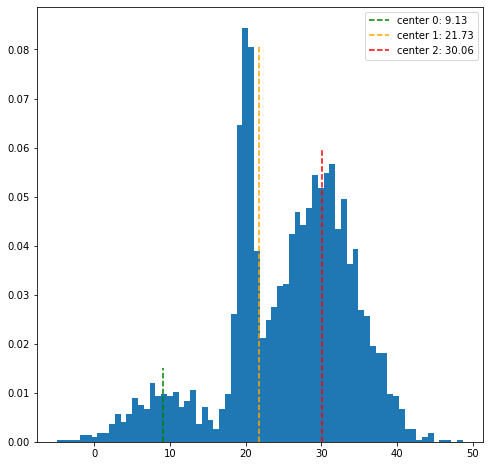

In [104]:
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique>=0])
print('Number of estimated clusters:',n_clusters)

cluster_centers = np.sort((scaler.inverse_transform(ms.cluster_centers_)),axis=0)

# plot
fig = plt.figure(figsize=(8,8))

fancyhist(data, 70, density=True);

colors = ['green','orange','red']
height = [0.015,0.081,0.06]
for i in range(len(cluster_centers)):
    plt.vlines(cluster_centers[i],0,height[i],color=colors[i],label='center %i: %.2f'%(i,cluster_centers[i]),ls='--')
    
plt.legend()

In [81]:
cluster_centers

array([[30.05931877],
       [21.72687065],
       [ 9.1329659 ]])